## Exp 03. Identifying novel bioisosterism

This file provides source codes for experimentation of novel bioisostere identification.

### Basics

In [1]:
import time
import json
import sys
import os
import os.path as op
from pathlib import Path
from collections import defaultdict
from copy import deepcopy
from datetime import datetime
from pathlib import Path
from typing import Dict, List
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem.FragmentMatcher import FragmentMatcher
from rdkit.Chem import BRICS
from rdkit.Chem import Draw
from rdkit.Chem.QED import properties as qed_properties

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from tqdm import tqdm

pd.options.mode.chained_assignment = None

import torch

torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

from conditioning import Conditioner
from generate import Generator
from model import DeepBioisostere
from property import calc_logP, calc_Mw, calc_QED, calc_SAscore
from brics.brics import BRICSModule

In [2]:
SMILES = str
CAPILTAIER = {"logp": "logP", "mw": "Mw", "qed": "QED", "sa": "SA"}
DELTA_PROPS = {
    "Mw": r"$\Delta Mw$",
    "logP": r"$\Delta logP$",
    "QED": r"$\Delta QED$",
    "SA": r"$\Delta SA$",
}
DE_DELTA_PROPS = {
    r"$\Delta Mw$": "Mw",
    r"$\Delta logP$": "logP",
    r"$\Delta QED$": "QED",
    r"$\Delta SA$": "SA",
}

### Define functions

In [3]:
def calculate_properties(smi: SMILES, props: List[str]) -> Dict[str, float]:
    mol = Chem.MolFromSmiles(smi)
    calculated_values = dict()
    for prop in props:
        if prop == "logp":
            calculated_values["logp"] = calc_logP(mol)
        elif prop == "mw":
            calculated_values["mw"] = calc_Mw(mol)
        elif prop == "qed":
            calculated_values["qed"] = calc_QED(mol)
        elif prop == "sa":
            calculated_values["sa"] = calc_SAscore(mol)
    return calculated_values

### Dataset Statistics

#### 10개 이상의 bioisostere가 없는 fragment는 몇개?

In [10]:
import pandas as pd
import os

frag_lib_path = "/home/hwkim/DeepBioisostere/fragment_library/fragment_library.csv"
processed_data_path = "/home/share/DATA/swkim/DeepBioisostere/processed_data.csv"

fragment_df = pd.read_csv(frag_lib_path, sep="\t")
data_df = pd.read_csv(processed_data_path, sep="\t")

print(fragment_df.head())
print(data_df.head())

/tmp/ipykernel_1423887/4008838098.py:7: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  fragment_df = pd.read_csv(frag_lib_path, sep="\t")


In [23]:
from collections import defaultdict
from tqdm import tqdm

print(fragment_df.columns)
print(data_df.columns)

all_frag_smis = list(set(fragment_df["FRAG-SMI"].tolist()))
print(f"\nTotal number of fragments: {len(all_frag_smis)}")

old_frag = data_df["OLD-FRAG"].tolist()
new_frag = data_df["NEW-FRAG"].tolist()

bioisosterism = defaultdict(set)
for old, new in tqdm(zip(old_frag, new_frag)):
    bioisosterism[old].add(new)
 
count = 0
for old, bioisosteres in bioisosterism.items():
    if len(bioisosteres) <= 10:
        count += 1
print(f"\nNumber of fragments with less than 10 bioisosteres: {count}")

Index(['INDEX', 'FRAG-SMI', 'FRAG-FREQ', 'NEW-OLD', 'DATA-TYPE', 'BRICS-TYPE'], dtype='object')
Index(['INDEX', 'REF-CID', 'PRB-CID', 'REF-SMI', 'PRB-SMI', 'ASSAY-ID',
       'REF-TARGET-ID', 'PRB-TARGET-ID', 'KEY-FRAG-ATOM-INDICE',
       'ATOM-FRAG-INDICE', 'OLD-FRAG', 'OLD-FRAG-FREQ', 'NEW-FRAG',
       'NEW-FRAG-IDX', 'ALLOWED-ATTACHMENT', 'DATATYPE'],
      dtype='object')

Total number of fragments: 145959


6997114it [00:04, 1443124.35it/s]


Number of fragments with less than 10 bioisosteres: 103017


### Main part

##### User settings for generation

In [29]:
# USER SETTINGS
PROJECT_DIR = Path("/home/hwkim/DeepBioisostere")   # Change this to your project directory
batch_size = 256
num_sample_each_mol = 100
device = "cpu"
properties = ["qed"]
num_procs = 4
new_frag_type = "all"

use_calc_csv_file = True

In [33]:
# frag_lib_path = PROJECT_DIR.joinpath("fragment_library")    # default path!
frag_lib_path = Path("/home/share/DATA/hwkim/DeepBioisostere")               # our own server...

# experiment settings
if use_calc_csv_file and op.exists("./csv_files/generation_results.csv"):
    print("Already calculated csv file is used.")
    calculated_csv_file = "./csv_files/generation_results.csv"
else:
    print("New csv file is to be calculated.")
    calculated_csv_file = None

model_path = Path(PROJECT_DIR).joinpath(f"model_save/DeepBioisostere_{'_'.join(properties)}.pt")

New csv file is to be calculated.


In [31]:
# Save directory setting
current_time = datetime.now().strftime("%b%d_%H-%M-%S")
save_dir = Path(current_time)
save_dir.mkdir(exist_ok=True)

##### Fragment library and DeepBioisostere generator setting

In [34]:
if calculated_csv_file is None:
    # Initialize model, conditioner, and generator
    model = DeepBioisostere.from_trained_model(model_path, properties=properties)
    conditioner = Conditioner(
        phase="generation",
        properties=properties,
    )
    generator = Generator(
        model=model,
        processed_frag_dir=frag_lib_path,
        num_sample_each_mol=num_sample_each_mol,
        device=device,
        num_cores=num_procs,
        batch_size=batch_size,
        new_frag_type=new_frag_type,
        conditioner=conditioner,
        properties=properties,
    )
else:
    generator = None

Loading the fragment library...
Generator initialization finished.


##### Generation

In [35]:
fragment_in_interest = "[14*]c1ccc2[nH]c([14*])cc2n1"
target_smi = "CN(C(=O)c1ccccc1)c1ccc2[nH]c(-c3n[nH]c4cc(C#N)ccc34)cc2n1"

In [36]:
if generator:
    # Remove BRICS type for fragment matching
    fragment_without_dummy = fragment_in_interest
    for i in range(1, 17):
        fragment_without_dummy = fragment_without_dummy.replace(f"[{i}*]", "[*]")
    fragment_matcher = FragmentMatcher()
    fragment_matcher.Init(fragment_without_dummy)
    matches = fragment_matcher.GetMatches(Chem.MolFromSmiles(target_smi))
    input_for_generation = [(target_smi, fragment_in_interest, matches[0][1], {"qed": 0.0})]

    # Generation
    print("Generation with DeepBioisostere is going on. It may take a while...")
    result_df = generator.generate_with_leaving_frag(input_for_generation)
    print("Done.")

    # Save the generation result csv file
    result_df.to_csv(f"{save_dir}/generation_results.csv", index=False)
    result_df.to_csv(calculated_csv_file, index=False)

else: 
    result_df = pd.read_csv(calculated_csv_file)

Generation with DeepBioisostere is going on. It may take a while...
Done.


##### Analysis

In [37]:
save_path = save_dir.joinpath("analysis_results.json")

if not save_path.exists():
    print("Arranging the results...")
    analyzed_results = defaultdict(dict)
    removal_frags = result_df["LEAVING-FRAG-SMI"].unique()
    for removal_frag in tqdm(removal_frags):
        # Arrange generated results
        generated_partial_df = result_df[
            # (result_df["INPUT-MOL-SMI"] == original_smi)
            (result_df["LEAVING-FRAG-SMI"] == removal_frag)
        ]
        original_smis = generated_partial_df["INPUT-MOL-SMI"].unique()

        for original_smi in original_smis:
            partial_df = generated_partial_df[generated_partial_df["INPUT-MOL-SMI"] == original_smi]
            generated_new_smis = partial_df["GEN-MOL-SMI"].tolist()[
                :num_sample_each_mol
            ]
            generated_inserting_frags = partial_df["INSERTING-FRAG-SMI"].tolist()[
                :num_sample_each_mol
            ]
            generated_predicted_probs = partial_df["PREDICTED-PROB"].tolist()[
                :num_sample_each_mol
            ]

            analyzed_results[removal_frag][original_smi] = {
                "generated": [
                    (gen_smi, gen_inserting_frag, predicted_prob)
                    for gen_smi, gen_inserting_frag, predicted_prob in zip(
                        generated_new_smis, generated_inserting_frags, generated_predicted_probs
                    )
                ]
            }

    with save_path.open("w") as fw:
        json.dump(analyzed_results, fw, indent=2)
else:
    print(f"Load the analysis results from {save_path}")
    with save_path.open("r") as fr:
        analyzed_results = json.load(fr)

Arranging the results...


100%|██████████| 1/1 [00:00<00:00, 255.56it/s]


##### Visualization

Generated QEDs
0.483	0.490	0.466	0.483	0.490	0.483	0.483	
0.463	0.483	0.466	0.476	0.463	0.486	0.483	
0.483	0.455	0.483	0.488	0.476	0.455	0.461	
0.490	0.479	0.472	0.484	0.483	0.429	0.428	
0.502	0.473	0.488	0.427	0.461	0.475	0.506	
0.490	0.462	0.455	0.445	0.449	0.449	0.472	
0.486	0.449	0.445	0.476	0.454	0.486	0.483	
0.420	

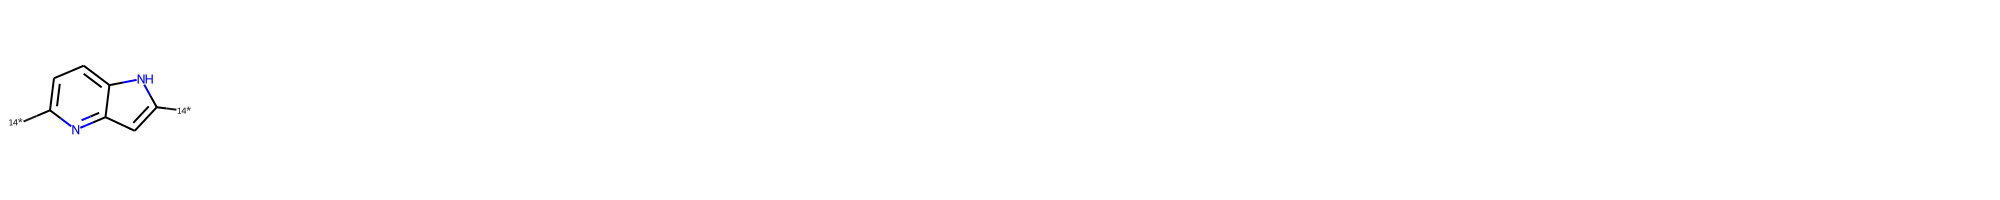

In [67]:
generation_inform = analyzed_results[fragment_in_interest][target_smi]
# answer_pairs = generation_inform["answers"]
generated_pairs = generation_inform["generated"][:50]
generated_molecules = [pair[0] for pair in generated_pairs]

generated_qeds = []
for gen_smi in generated_molecules:
    gen_mol = Chem.MolFromSmiles(gen_smi)
    generated_qeds.append(calc_QED(gen_mol))

print("Generated QEDs")
for idx, qed in enumerate(generated_qeds):
    print(f"{qed:.3f}", end="\t"+"\n"*(idx % 7 == 6))
Draw.MolsToGridImage([Chem.MolFromSmiles(fragment_in_interest)], molsPerRow=10, subImgSize=(200, 200), maxMols=100)


[14*]c1ncc2cc([16*])ccc2n1, [14*]c1nnc2cc([16*])ccc2n1, [4*]Cc1ccc2nc([14*])[nH]c2c1, [14*]c1cc2ccc([16*])cc2nn1, [14*]c1ncc2cc([16*])cnc2n1, 
[14*]c1ccc2cc([16*])cnc2n1, [14*]c1cnc2cc([16*])ccc2n1, [14*]c1ccc2cc([16*])ccc2n1, [14*]c1cc2ncc([16*])cc2cn1, [4*]Cc1ccc2[nH]c([14*])nc2c1, 
[14*]c1nc2cc([16*])cnc2s1, [14*]c1cc2ccc([16*])cc2cn1, [14*]c1nc2cc([16*])c[nH]c-2n1, [14*]c1ccc2nc([14*])ccc2n1, [14*]c1cc2ccc([14*])nc2cn1, 
[14*]c1nc2cc([16*])ccc2s1, [14*]c1cc2ccc([14*])nc2cn1, [4*]Cc1ccn2cc([14*])nc2c1, [14*]c1nc2ncc([16*])cc2s1, [14*]c1nc2ccc([16*])cc2s1, 
[14*]c1nc(C)c2cc([16*])ccc2n1, [14*]c1cnc2nc([14*])ccc2n1, [14*]c1nc2cc([16*])ccc2[nH]1, [4*]Cc1ccc2oc([14*])nc2c1, [14*]c1cnc2sc([14*])nc2n1, 
[14*]c1cc2cnc([14*])cc2cn1, [1*]C(=O)c1nc2cc([16*])ccc2[nH]1, [14*]c1ncc2cc([16*])cc(Cl)c2n1, [14*]c1cc2ccc([16*])cn2n1, [14*]c1nnc2cc([16*])cc(C)c2n1, 
[4*]Cc1ccn2c([14*])cnc2c1, [14*]c1nnc2cc([16*])cc(N)c2n1, [14*]c1ncc2cc([16*])cc(C)c2n1, [14*]c1cc(-n2cnc([14*])c2)ccn1, [14*]c1nc2ccc([

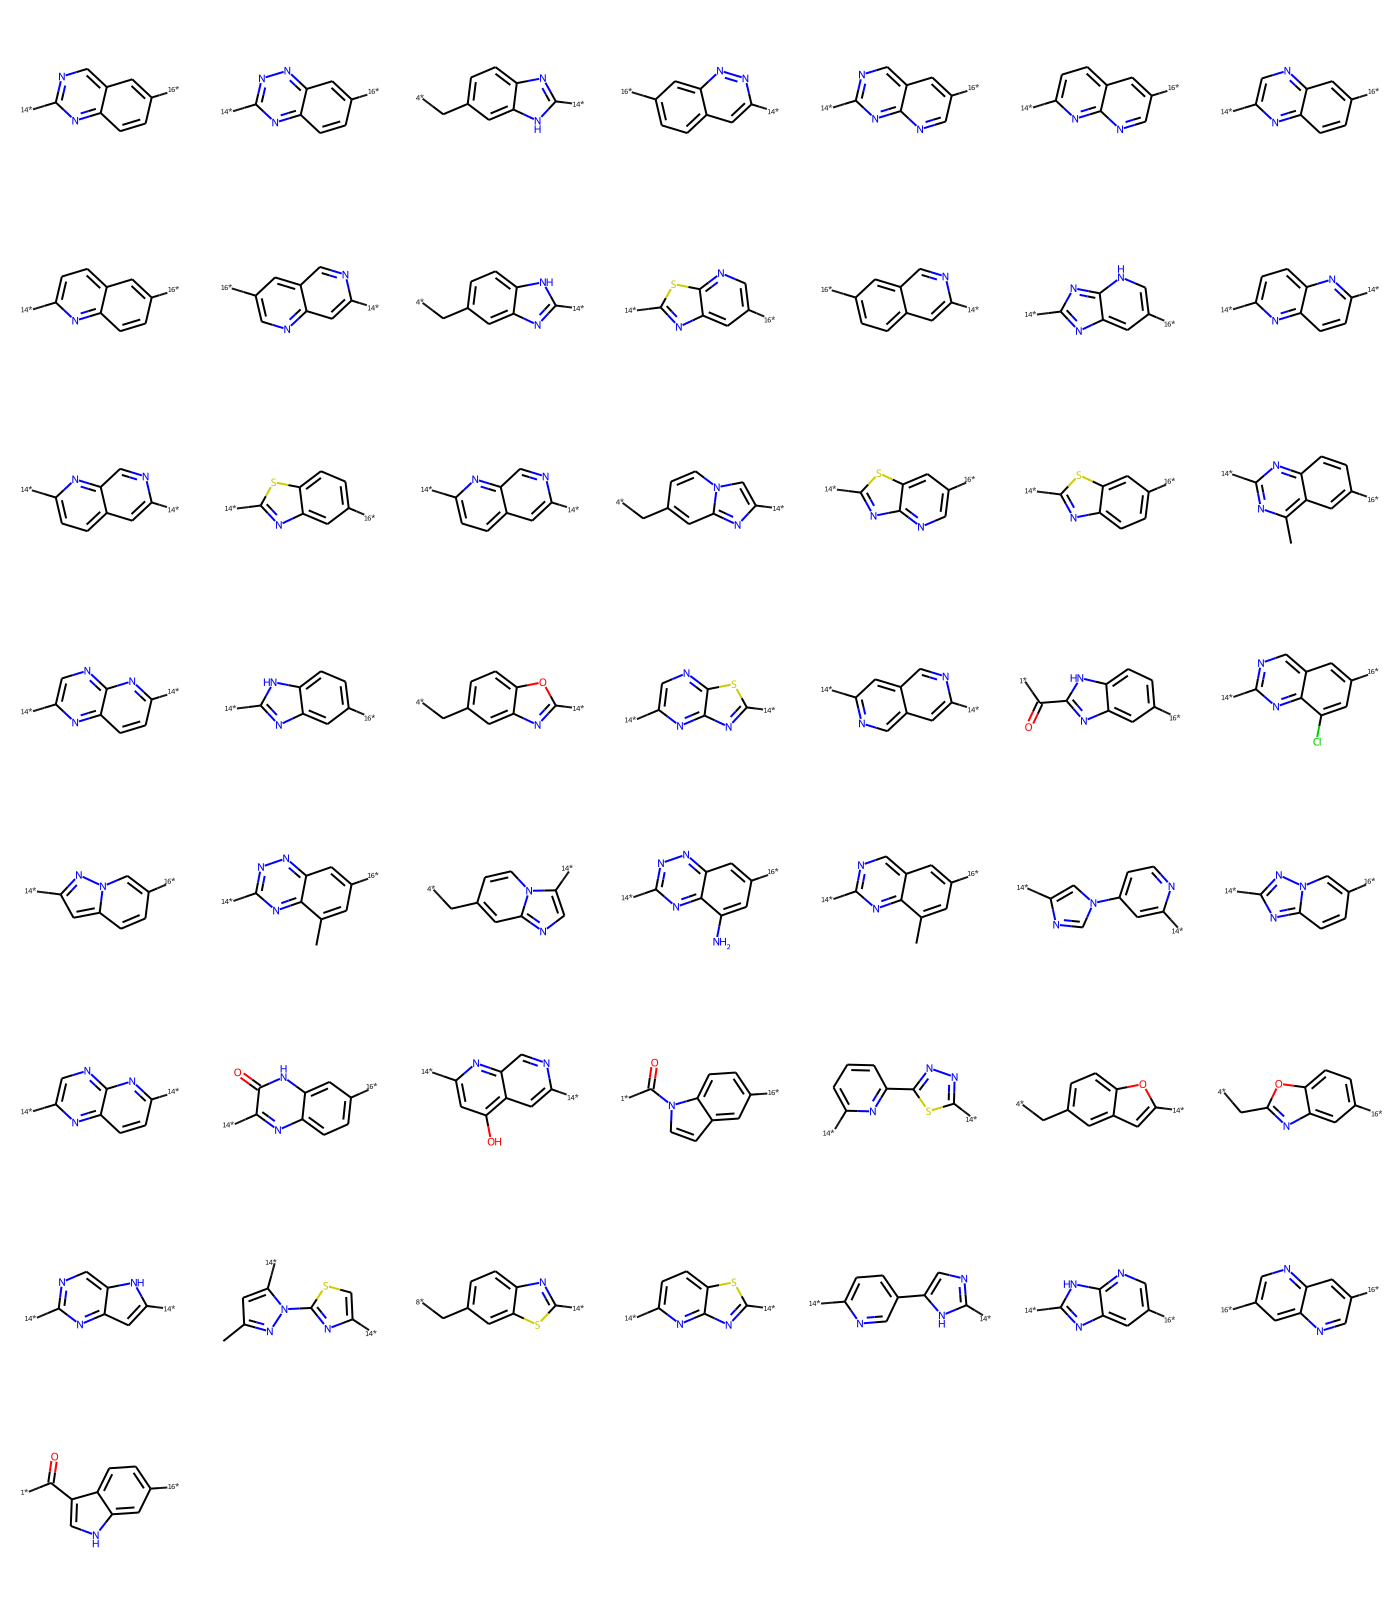

In [39]:
from rdkit.Chem import Draw

# Visualize the selected fragments
generated_molecules, generated_frags, predicted_probs = zip(*generated_pairs)
generated_frags = list(generated_frags)
num_line_break = len(generated_frags)/5

generated_frags_copy = deepcopy(generated_frags)
for i in range(int(num_line_break)):
    generated_frags[5*i] = "\n" + generated_frags[5*i]
print(", ".join(generated_frags))

# Draw the generated molecules and save the image
Draw.MolsToGridImage([Chem.MolFromSmiles(frag) for frag in generated_frags_copy], molsPerRow=7, subImgSize=(200, 200), maxMols=100)

##### Plot distributions

original QED: 0.4790033628653537


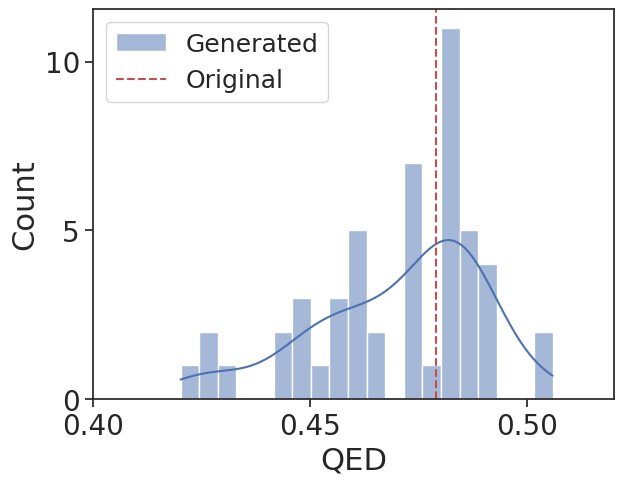

In [85]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
sns.set_theme(style="ticks")

# Calucate generated properties
original_qed = calc_QED(Chem.MolFromSmiles(target_smi))
print(f"original QED: {original_qed}")

data = pd.DataFrame({
    "QED": generated_qeds,
    "CASE": "Generated Molecules"
})

# kdeplot without histogram
g = sns.histplot(
    data=data,
    x = "QED",
    hue = "CASE",
    legend=False,
    label = "Generated Molecules",
    bins = 20,
    kde=True,
    kde_kws={
        "cut": 0,               # don’t extend past min/max of data
        "clip": (0.40, 0.52),   # hard-clip the KDE to your x-limits
    },
)
plt.fill_between(x=data["QED"], y1=0, alpha=0.3)
plt.axvline(x=original_qed, color="r", linestyle="--", label="Original Molecule")

# Setting font sizes
g.axes.set_xlabel("QED", fontsize=22)
g.axes.set_ylabel("Count", fontsize=22)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[1], handles[0]], ["Generated", "Original"], loc="upper left", fontsize=18)

x_ticks = list(g.axes.get_xticks())
y_ticks = list(g.axes.get_yticks())

x_min, x_max = x_ticks[0], x_ticks[-1]
x_min = round(x_min * 20) / 20
x_max = round(x_max * 20) / 20
if x_max-x_min > 1.0:
    tick_size = 0.2
else:
    tick_size = 0.05
x_ticks = list(np.arange(x_min, x_max + 0.02, tick_size))
g.axes.set_xlim(0.40, 0.52)

y_min, y_max = y_ticks[0], y_ticks[-1]
y_ticks = list(np.arange(y_min, y_max, 5))

g.axes.set_xticks(x_ticks)
g.axes.set_yticks(y_ticks)
g.axes.set_xticklabels(g.axes.get_xticklabels(), fontsize=20)
g.axes.set_yticklabels(g.axes.get_yticklabels(), fontsize=20)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.savefig(f"{save_dir}/kde_qed_generated_molecules.pdf", format="pdf", facecolor="white")
plt.show()